# Recommendations Systems
## Assignment 3:  Neural Collaborative Filtering

**The goal of this assignment is to:**
- Understand the concept of recommendations based on implicit data which is very common in real life.
- Understand how DL components can be used to implement a collaborative filtering & hybrid approach recommenders.
- Understand pros&cons comparing to other recommender system approaches.
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6 should be used. 
- You may use Torch/Keras/TF packeges.
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).

**LINKS:**
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>Dataset</a>
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>Repository</a>
- <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>Blog Post Review</a>
<br>

**Google <a href='https://colab.research.google.com/'>Colaboratory</a>**  
        
    This is a great academic tool for students. Instead of installing and running "everything" on your Laptop - which probably will take you a lot of time - you can use Google Colab.  
    Basically, you can use it for all your Python needs.  

**PyTorch <a href='https://pytorch.org/tutorials/beginner/basics/intro.html'>Tutorials</a>**   
    
    Just follow steps 0-7 and you will have the basics skills to understand, build, and run DL recommender models. 

**Keras Kaggle's <a href='https://www.kaggle.com/learn/intro-to-deep-learning'>intro-to-deep-learning</a>**  
    
    This will give you a quick idea of what DL is, and how to utilize it.  
    They're using TensorFlow, while in our MLDL program we're using PyTorch.  




**Grading:**

- Q1 - 20 points - Dataset Preparation
- Q2 - 50 points - Neural Collaborative Filtering
- Q3 - 30 points - Loss Function

`Total: 100`

<br><br><br>

**Prerequisites**

In [ ]:
#!pip install --quiet

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan  9 09:29:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


**Imports**

In [ ]:
# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import scipy.sparse as sp

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# visual 3D
from mpl_toolkits import mplot3d

# notebook
from IPython.display import display, HTML


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

# Keras
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate

# colab
# from google.colab import drive  

**Hide Warnings**

In [ ]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset Preparation (Ingestion)
<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>
(feel free to use visual explanations)
<br>

a. **Explain** the role and structure of each file and how it was created from the original <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>MovieLens 1M rating dataset</a>.

They use two datasets provided with the papar and their implementation: MovieLens 1 Million (ml-1m) and Pinterest (pinterest-20).
We will focuse in this assignment on the MovieLens files.

**ml-1m.train.rating:** </br>
  Role - training data (positive instances)</br>
  Structure - User ID | Item ID| Rating | Timestamp </br>
  Dataset Creation - this file was created from the original MovieLens dataset (rating.dat), each row is a positive train instance of interactions between user and item. 


**ml-1m.test.rating:** </br>
Role - test data (positive instances)</br>
Structure - User ID | Item ID| Rating | Timestamp </br>
Dataset Creation - this file was created from the original MovieLens dataset (rating.dat), each row is a positive test instance of interactions between user and item. They took only the last item with the highest timestamp of each user.

**ml-1m.test.negative:** </br>
Role - test data (negative instances)</br>
Structure - (User ID, Item ID) | Negative Item ID| Negative Item ID | Negative Item ID | .. </br>
Dataset Creation - this file was created from the original MovieLens dataset (rating.dat), each row is a negative test instance of user and item that there was no interaction between them. the first column represent the user and the last item he had an interaction with. for each user, they took 99 items that the user didn't interacte with them (negative instance).

b. **Explain** how the training dataset is created.

The training dataset was generated explicitly from the rating.dat dataset,
from the original MovieLens 1M dataset. 

c. **Explain** how the test dataset is created.

The test dataset was generated explicitly from the rating.dat dataset,
from the original MovieLens 1M dataset and for each user they took the last item with that he had interation with according to the highest timestamp.

#### Data Preperations:

In [ ]:
#Creating Explicit dataset
class Dataset(object):
    """
    This class is a wrapper for the movie lens 1M dataset
    """
    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_rating_file_as_matrix(path + "ml-1m.train.rating")
        self.testRatings = self.load_rating_file_as_list(path + "ml-1m.test.rating")
        self.testNegatives = self.load_negative_file(path + "ml-1m.test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat

In [ ]:
! git clone https://github.com/hexiangnan/neural_collaborative_filtering.git

fatal: destination path 'neural_collaborative_filtering' already exists and is not an empty directory.


In [ ]:

DATASET_PATH = '/content/neural_collaborative_filtering/Data/'
dataset = Dataset(DATASET_PATH)

train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.shape
print("Load data done #user=%d, #item=%d, #train=%d, #test=%d" 
      %(num_users, num_items, train.nnz, len(testRatings)))

Load data done #user=6040, #item=3706, #train=994169, #test=6040


In [ ]:
#View sample from training set
#First 2 users, first 20 items
print(train[0:2,0:20])

  (0, 0)	1.0
  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (1, 0)	1.0
  (1, 18)	1.0


In [ ]:
#View test ratings
testRatings[0:5]

[[0, 25], [1, 133], [2, 207], [3, 208], [4, 222]]

In [ ]:
#View first 5 negative item for first sample
testNegatives[0][0:5]

[1064, 174, 2791, 3373, 269]

<br><br><br>
<br><br><br>


## Question 2: Neural Collaborative Filtering 
<br><br>

## a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)


**Matrix Factorization (MF)**

In [ ]:
def get_MF_model(num_users, num_items, latent_dim, regs=[[0,0]]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)  
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    prediction = keras.layers.dot([user_latent,item_latent], axes=1,normalize=False)
    #prediction = Multiply()([user_latent, item_latent]) 

    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

**Multi Layer Perceptron (MLP)**
<br>
![image.png](attachment:image.png)

In [ ]:
def get_MLP_model(num_users, num_items, latent_dim, regs=[[0,0],0,0], layers = [20,10]):    
    assert len(layers) + 1 == len(regs), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) 
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) 
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    vector = Concatenate(axis=-1)([user_latent, item_latent]) 
    
    for idx in range(num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(regs[idx+1]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

**Generalized Matrix Factorization (GMF)**


In [ ]:
def get_GMF_model(num_users, num_items, latent_dim, regs=[[0,0]]):
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) 
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    predict_vector = Multiply()([user_latent, item_latent])

    
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

**NeuroMatrixFactorization (NMF)**

In [ ]:
def get_NMF_model(num_users, num_items, latent_dim_GMF, latent_dim_MLP, reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0], layers=[20,10]):
    #Neural matrix factorization
    assert len(layers) + 1 == len(regs_MLP), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_GMF, name = 'MF_user_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) 
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_GMF, name = 'MF_item_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  
    
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_MLP, name = 'MLP_user_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_MLP, name = 'MLP_item_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) 

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(num_layer):
        layer =  Dense(layers[idx], kernel_regularizer = l2(regs_MLP[idx+1]), activation='tanh', name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

<br><br><br><br>

## b. Train and evaluate the recommendations accuracy of the models: 
- MF
- GMF
- MLP
- NMF

Compare the learning curve and recommendations accuracy using NDCG and MRR metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Metrics:**
- HitRatio
- nDCG
- MRR

**Evaluation:**

In [ ]:
import math
import heapq # for retrieval topK
import multiprocessing
import numpy as np
from time import time
#from numba import jit, autojit

# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, mrrs = [],[], []
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        mrr = [r[2] for r in res]
        return (hits, ndcgs, mrr)
    # Single thread
    for idx in range(len(_testRatings)):
        (hr, ndcg, mrr) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)
        mrrs.append(mrr)
    return (hits, ndcgs, mrrs)

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr = getMRR(ranklist, gtItem)
    return (hr, ndcg, mrr)

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

def getMRR(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return 1 / (i + 1)
    return 0

**HyperParams:**

In [ ]:
#Selected hyperparameters
num_negatives = 4 
learning_rate = 0.001
epochs = 10
batch_size = 256
verbose = 1
evaluation_threads = 1 
write_model=False
topK = 10


models = [get_MF_model(num_users, num_items, latent_dim = 20, regs = [[0,0]]),
          get_GMF_model(num_users, num_items, latent_dim = 20, regs=[[0,0]]),
          get_MLP_model(num_users, num_items, latent_dim = 8, regs = [[0,0],0,0,0], layers = [32,16,8]),
          get_NMF_model(num_users, num_items, latent_dim_GMF = 8, latent_dim_MLP = 8, reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0,0], layers=[32,16,8]) ]

model_names = ['MF', 'GMF', 'MLP', 'NMF']

for model, model_name in zip(models, model_names):
    print(model.summary())
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 20)        120800      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 20)        74120       ['item_input[0][0]']             
                                                                                              

<br><br>
Create train data:

In [ ]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

<br><br>
Train & Eval:

In [ ]:
epochs = 10
results = pd.DataFrame(
          {col: np.nan for col in ['time','hr5', 'hr10', 'ndcg5', 'ndcg10', 'mrr5', 'mrr10']},
          index=model_names)
losses = pd.DataFrame({col: np.nan for col in model_names}, index=range(0,epochs))

for model, model_name in zip(models, model_names):
    loss_hist = []
    t1 = time()

    print(f'Training model: {model_name}')
    for epoch in range(1, epochs + 1):
        # Generate training instances
        user_input, item_input, labels = get_train_instances(train, num_negatives)
        
        # Training
        hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size=batch_size, epochs=1, verbose=0, shuffle=True)

        print('Epoch {0}\t time: {1:.3f} seconds'.format(epoch, time() - t1))

        loss_hist.append(hist.history['loss'][0])
    
    end = time()
    results.loc[model_name,'time'] = np.round((end - t1)/60,4)
    losses[model_name] = pd.Series(loss_hist)
    #Calculate metrics
    (hits5, ndcgs5, mrr5) = evaluate_model(model, testRatings, testNegatives, 5, evaluation_threads) 
    hr5, ndcg5, mrr5 = np.array(hits5).mean(), np.array(ndcgs5).mean(), np.array(mrr5).mean()

    (hits10, ndcgs10, mrr10) = evaluate_model(model, testRatings, testNegatives, 10, evaluation_threads)
    hr10, ndcg10, mrr10 = np.array(hits10).mean(), np.array(ndcgs10).mean(), np.array(mrr5).mean()

    results.loc[model_name, 'hr5'] = hr5
    results.loc[model_name, 'hr10'] = hr10
    results.loc[model_name, 'ndcg5'] = ndcg5
    results.loc[model_name, 'ndcg10'] = ndcg10
    results.loc[model_name, 'mrr5'] = mrr5
    results.loc[model_name, 'mrr10'] = mrr10

print("Train complete")

Training model: MF
Epoch 1	 time: 81.931 seconds
Epoch 2	 time: 162.696 seconds
Epoch 3	 time: 243.330 seconds
Epoch 4	 time: 323.747 seconds
Epoch 5	 time: 404.084 seconds
Epoch 6	 time: 484.487 seconds
Epoch 7	 time: 565.104 seconds
Epoch 8	 time: 645.501 seconds
Epoch 9	 time: 725.852 seconds
Epoch 10	 time: 806.112 seconds
Training model: GMF
Epoch 1	 time: 72.047 seconds
Epoch 2	 time: 142.910 seconds
Epoch 3	 time: 213.931 seconds
Epoch 4	 time: 284.693 seconds
Epoch 5	 time: 355.412 seconds
Epoch 6	 time: 426.485 seconds
Epoch 7	 time: 497.789 seconds
Epoch 8	 time: 568.858 seconds
Epoch 9	 time: 639.757 seconds
Epoch 10	 time: 710.773 seconds
Training model: MLP
Epoch 1	 time: 78.447 seconds
Epoch 2	 time: 156.099 seconds
Epoch 3	 time: 234.081 seconds
Epoch 4	 time: 311.854 seconds
Epoch 5	 time: 389.341 seconds
Epoch 6	 time: 467.235 seconds
Epoch 7	 time: 545.020 seconds
Epoch 8	 time: 622.619 seconds
Epoch 9	 time: 700.406 seconds
Epoch 10	 time: 778.465 seconds
Training mo

<br><br><br><br>
All Results:

In [ ]:
results

,time,hr5,hr10,ndcg5,ndcg10,mrr5,mrr10
MF,13.4352,0.493212,0.667550,0.335919,0.392385,0.284230,0.284230
GMF,11.8462,0.512583,0.685430,0.351525,0.407520,0.298496,0.298496
MLP,12.9744,0.438411,0.626656,0.296446,0.357338,0.249807,0.249807
NMF,13.9915,0.486589,0.665232,0.330944,0.388858,0.279851,0.279851


<br><br><br><br>
Train & Validation Loss:

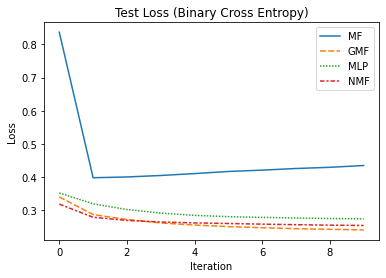

In [ ]:
fig, axes = plt.subplots()
sns.lineplot(data=losses)
axes.set_title('Test Loss (Binary Cross Entropy)')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.show()

We noticed that besides for MF model all other models have a loss that converges. MF loss is increasing after 1 iteration which means the learning rate it too large or the model is overfitting the training data leading to increase in test loss. 

Training Time:

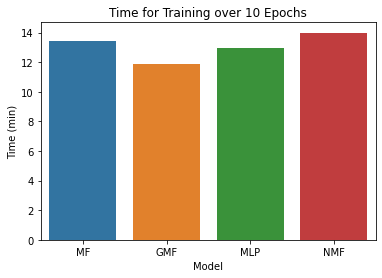

In [ ]:
fig, axes = plt.subplots()
sns.barplot(data = results, x = results.index, y = 'time')
axes.set_title(f'Time for Training over {epochs} Epochs')
axes.set_xlabel('Model')
axes.set_ylabel('Time (min)')
plt.show()

Metric Evaluation:

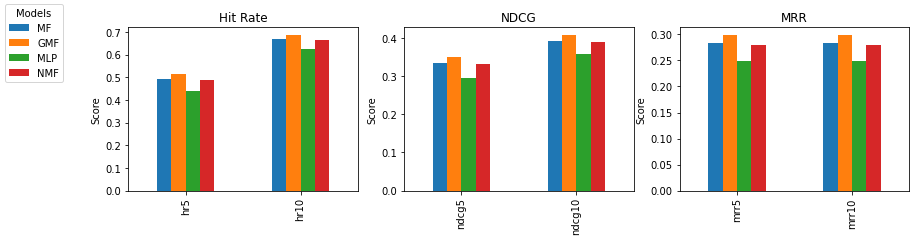

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (14,3))
metrics = ['hr', 'ndcg', 'mrr']

for i , m in enumerate(metrics):
  results[[f'{m}5', f'{m}10']].transpose().plot(kind='bar', ax = axes[i], legend = False)
  axes[i].set_ylabel('Score')
  if m == 'hr':
    axes[i].set_title('Hit Rate')
  elif m == 'ndcg':  
    axes[i].set_title('NDCG')
  elif m == 'mrr':
    axes[i].set_title('MRR')

fig.legend( labels=model_names,   
           loc="upper left",   
           title="Models"  
           )
plt.show()

<br><br><br><br>

**c. How the values of MRR and NDCG are differ from the results you got in the previous exercises which implemented the explicit recommendation approach. What are the difference in preparing the dataset for evaluation.**

The values of MRR and NDCG are lower than we got the previous exercises, it makes sense because we used different dataset for the recommendations. Our data was very sparse and this could of had an impact.In this exercise we used implicit dataset based on ratings and the other were related to explicit dataset. </br>
The difference in preparing the datasets for evaluation is that here we used also negative instances. 

**d. How will you measure item similarity using the NeuMF model?**

To measure item simillarity using the NeuMF model, we should extract their latent representation that provies a representation of the item in lower dimension. The user and item vectors are calculated by the first layer following the input layers.

In the NeuMF model, the users and item vectors are first transformed into latend vectors. Then this output is concatenated and used as intput for the neural net. While training, the neural network learns and updates the weights of these two first layers to learn the optimal embedding for the task. After training we can extract the weights matrix of the first layer for item vectors. Then we get that each column (column and not row since the input vector is one-hot encoded) in that matrix will be a latent vector representation of an item.

Once we have the item vector representation (the latend vector) we can use any correlation metric like those used in assignment 1 (cosine, pearson, etc.) 

<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Loss Function 
<br><br>

#### a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.   

Select one of the models you implemented in question 2 and change the loss function to a `Mean Squared Error` and the activation function of the last layer to `RELU`.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

In [ ]:
def get_MLP_model_2(num_users, num_items, latent_dim, regs=[[0,0],0,0],  layers = [20,10], final_layer='sigmoid'):
    #Multi-Layer Perceptron
    
    assert len(layers) + 1 == len(regs), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    print(f'regs : {regs[0][0]}')
    print(f'regs : {regs[0][1]}')
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', \
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', \
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    

    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])
    
    # MLP layers
    for idx in range(num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(regs[idx+1]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation=final_layer, kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    return model

In [ ]:
num_factors = 8
num_negatives = 4 
learning_rate = 0.001
epochs = 10
batch_size = 256
verbose = 1
write_model=False
topK = 10 
evaluation_threads = 1 

relu_mlp_model = get_MLP_model_2(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8], final_layer='relu')
mse_mlp_model = get_MLP_model_2(num_users, num_items, num_factors, regs = [[0,0],0,0,0],\
                              layers = [32,16,8], final_layer='sigmoid')
relu_mse_mlp_model = get_MLP_model_2(num_users, num_items, num_factors, regs = [[0,0],0,0,0],\
                                   layers = [32,16,8], final_layer='relu')

new_models = [relu_mlp_model, mse_mlp_model, relu_mse_mlp_model]
new_model_names = ['entropy_relu_mlp', 'mse_sigmoid_mlp', 'mse_relu_mlp']

for model, model_name in zip(new_models, new_model_names):
    if 'mse' in model_name:
        model.compile(optimizer=Adam(lr=learning_rate), loss='mse')
        print('compiled {} with MSE loss'.format(model))
    else:
        model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
        print('compiled {} with cross entropy loss'.format(model))
    print(model.summary())




regs : 0
regs : 0
regs : 0
regs : 0
regs : 0
regs : 0
compiled <keras.engine.functional.Functional object at 0x7f564b0ef690> with cross entropy loss
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 8)         48320       ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 

In [ ]:
epochs = 10
results_new = pd.DataFrame(
          {col: np.nan for col in ['time','hr5', 'hr10', 'ndcg5', 'ndcg10', 'mrr5', 'mrr10']},
          index=new_model_names)
losses_new = pd.DataFrame({col: np.nan for col in new_model_names}, index=range(0,epochs))


for model, model_name in zip(new_models, new_model_names):
    loss_hist = []
    t1 = time()
    print(f'Training model: {model_name}')
    for epoch in range(1, epochs + 1):
        # Generate training instances
        user_input, item_input, labels = get_train_instances(train, num_negatives)
        
        # Training
        hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size=batch_size, epochs=1, verbose=0, shuffle=True)

        print('Epoch {0}\t time: {1:.3f} seconds'.format(epoch, time() - t1))

        loss_hist.append(hist.history['loss'][0])

    
    end = time()
    results_new.loc[model_name,'time'] = np.round((end - t1)/60,4)
    losses_new[model_name] = pd.Series(loss_hist)
    #Calculate metrics
    (hits5, ndcgs5, mrr5) = evaluate_model(model, testRatings, testNegatives, 5, evaluation_threads) 
    hr5, ndcg5, mrr5 = np.array(hits5).mean(), np.array(ndcgs5).mean(), np.array(mrr5).mean()

    (hits10, ndcgs10, mrr10) = evaluate_model(model, testRatings, testNegatives, 10, evaluation_threads)
    hr10, ndcg10, mrr10 = np.array(hits10).mean(), np.array(ndcgs10).mean(), np.array(mrr5).mean()

    results_new.loc[model_name, 'hr5'] = hr5
    results_new.loc[model_name, 'hr10'] = hr10
    results_new.loc[model_name, 'ndcg5'] = ndcg5
    results_new.loc[model_name, 'ndcg10'] = ndcg10
    results_new.loc[model_name, 'mrr5'] = mrr5
    results_new.loc[model_name, 'mrr10'] = mrr10



print("Train complete")

Training model: entropy_relu_mlp
Epoch 1	 time: 78.630 seconds
Epoch 2	 time: 157.893 seconds
Epoch 3	 time: 235.996 seconds
Epoch 4	 time: 314.436 seconds
Epoch 5	 time: 392.265 seconds
Epoch 6	 time: 470.170 seconds
Epoch 7	 time: 548.310 seconds
Epoch 8	 time: 626.624 seconds
Epoch 9	 time: 704.515 seconds
Epoch 10	 time: 782.303 seconds
Training model: mse_sigmoid_mlp
Epoch 1	 time: 74.552 seconds
Epoch 2	 time: 148.091 seconds
Epoch 3	 time: 222.265 seconds
Epoch 4	 time: 295.781 seconds
Epoch 5	 time: 369.461 seconds
Epoch 6	 time: 443.162 seconds
Epoch 7	 time: 517.324 seconds
Epoch 8	 time: 590.762 seconds
Epoch 9	 time: 664.334 seconds
Epoch 10	 time: 737.771 seconds
Training model: mse_relu_mlp
Epoch 1	 time: 74.134 seconds
Epoch 2	 time: 148.060 seconds
Epoch 3	 time: 221.809 seconds
Epoch 4	 time: 295.520 seconds
Epoch 5	 time: 369.380 seconds
Epoch 6	 time: 442.948 seconds
Epoch 7	 time: 516.581 seconds
Epoch 8	 time: 590.330 seconds
Epoch 9	 time: 663.987 seconds
Epoch 10

<br><br><br><br>
<br><br><br><br>
NMFs Results:

In [ ]:
print('Metrics after training on 10 epochs')
results_new

Metrics after training on 10 epochs


,time,hr5,hr10,ndcg5,ndcg10,mrr5,mrr10
entropy_relu_mlp,13.0384,0.434768,0.623013,0.290292,0.351139,0.242947,0.242947
mse_sigmoid_mlp,12.2962,0.450828,0.626325,0.305207,0.361868,0.257301,0.257301
mse_relu_mlp,12.2862,0.450000,0.632947,0.304806,0.363711,0.257202,0.257202


In [ ]:
#Add MF results from previous section to results_new to compare in below graphs
all_MLP = pd.concat([results_new, results.loc[['MLP']]])

<br><br><br>
<br><br><br>

Train & Validation Loss:

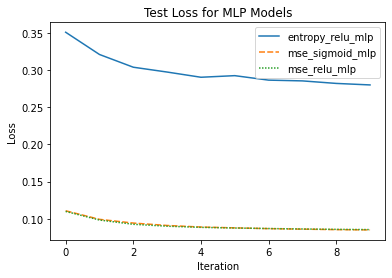

In [ ]:
# plot
fig, axes = plt.subplots()
sns.lineplot(data=losses_new)
axes.set_title('Test Loss for MLP Models')
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.show()

<br><br><br>
Training Time:

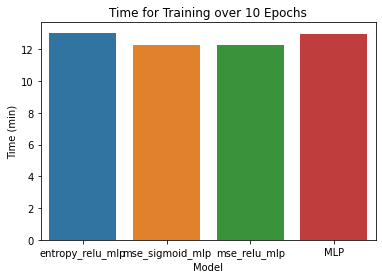

In [ ]:
# plot
#MLP model in red refers to model from section above - last layer activation is sigmoid with binary cross entropy loss
fig, axes = plt.subplots()
sns.barplot(data = all_MLP, x = all_MLP.index, y = 'time')
axes.set_title(f'Time for Training over {epochs} Epochs')
axes.set_xlabel('Model')
axes.set_ylabel('Time (min)')
plt.show()

<br><br><br>
Metric Evaluation:

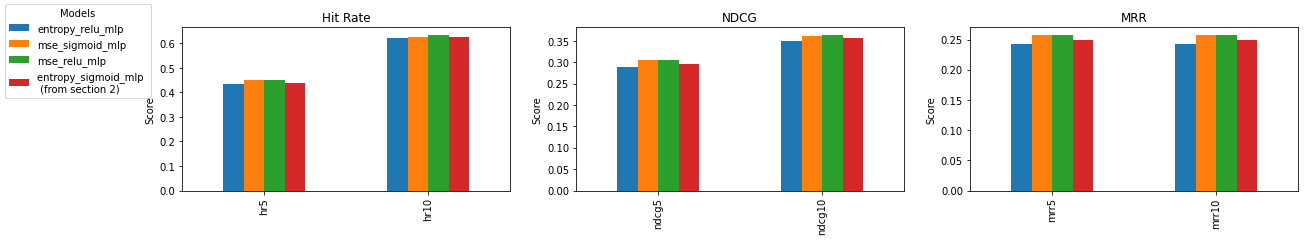

In [ ]:
# plot
fig, axes = plt.subplots(1,3, figsize = (20,3))
metrics = ['hr', 'ndcg', 'mrr']

for i , m in enumerate(metrics):
  all_MLP[[f'{m}5', f'{m}10']].transpose().plot(kind='bar', ax = axes[i], legend = False)
  axes[i].set_ylabel('Score')
  if m == 'hr':
    axes[i].set_title('Hit Rate')
  elif m == 'ndcg':  
    axes[i].set_title('NDCG')
  elif m == 'mrr':
    axes[i].set_title('MRR')

fig.legend( labels=new_model_names + ['entropy_sigmoid_mlp \n (from section 2)'],  
           loc="upper left",  
           title="Models"  
           )
plt.show()

<br><br>
**Conclusions:**

Loss Function:
- The MSE loss function returned slightly better results compared to the binary cross entropy loss. We were suprised at these findings since usually entropy is better forming when 2-class classification. Here the 2-classes are recommend vs. not-recommend. 
- If we were classifying based on ratings and using 5-classes for classification (1 being low rated/not recommended and 5 being high rated/top recommended) then the results of the MSE models may be different. 
- Another hypothesis of why MSE outperformed entropy is due to the data we are working with. The sparsity of the data and the way the test data is selected may have an impact. 
- The MSE models's test loss were siginificantly lower than the entropy loss. This goes to show that the MSE penalizes relatively little compared the entropy when the prediction is wrong and this is due to the loss is calculated. The MSE evaluates based on the range of y - y_predicted, which in this 2-class prediction model is limited. 

Activation function (In last layer):
- Using the MSE loss, the Relu activation function performs slightly better in a few metrics but overall there is no significance. However, using the entropy loss the sigmoid function performs slightly better across all metrics. 
- Since we are using short network, we don't run into te issue of the vanishing gradient. So for MSE case, there is no advantage to using Relu, which comes to sovle vanishing gradient issue. 
- The sigmoid function on the last layer seems to be the right choice for a probalistic model but we are not sure how to explain it mathematically.

Overall:
- These models were trained in Google Colab Pro version. 
- While we were able to run all models in a single runtime it is important to note that the MSE models were able to train slightly faster on 10 epochs. If wanted to train for 100 epochs or increase the parameters in these models, runtime may become more of an issue and MSE models would be preferred. 
- The metrics @10 were higher than the metrics @5 besides for MRR metrics. This is expected as the more predictions that are given, the better chances of success. MRR@5 and MRR@10 were the same because MRR models the rank of the top item, while the rest of the metrics measure in topK items. 
- The best performing model (MSE Relu MLP) was the best performing in all metrics.
- Our next steps would be the implement the MSE Relu MLP as part of the NMF model and hope to see even better results. 



<br><br>
<br><br>


Good Luck :)